**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [21]:
import math
import random
import numpy as np
import sympy as sm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from IPython.display import display
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [22]:
#We do the first order condition of the utility function against L and equalize it to zero
alpha, kappa, v, w, w_star, tau, g, l = sm.symbols("alpha, kappa, v, w, w_star, tau, g, l")

u=sm.ln((kappa + w_star * l)**alpha * g**(1 - alpha)) -  v * l**2/2

u_diff=sm.diff(u,l)

sol = sm.solve(sm.Eq(u_diff,0),l)

legend = "This is the analytical solution of the maximization: sol[0] " \
         "#this answer is mathematically the same as the equation for L*."

# Print the solution with the legend
print(legend)
print("Solution:")
sol[0] #this answer is mathematically the same as the equation for L*.

This is the analytical solution of the maximization: sol[0] #this answer is mathematically the same as the equation for L*.
Solution:


(-kappa*v - sqrt(v*(4*alpha*w_star**2 + kappa**2*v)))/(2*v*w_star)

In [23]:
# We can also do the maximization and compare the results

#We first set the parameters
alpha = 0.5
kappa = 1.0
v = 1 / (2 * 16 ** 2)
w = 1.0
tau = 0.30

# We write the utility function including the restriction in it
def c(l, kappa, tau, w):  #restriction
    w_star = (1 - tau) * w
    return kappa + w_star * l

def u(c, l, alpha, v, g): #utility
    if math.isclose((c**alpha * g**(1 - alpha)),0) : #if the value of the expression inside the log is close to zero, the utility is - infinity
        utility = float('-inf')
    else :
        utility = math.log(c**alpha * g**(1 - alpha))
    
    desutility = v * (l**2)/2

    return utility - desutility

def maximize_u():
    obj = lambda l: -u(c(l, kappa, tau, w), l, alpha, v, g)
    res = optimize.minimize_scalar(obj, bounds=(0, 24), method='bounded')
    return res.x

# We will now perform this maximization for the different values of g and check if it is close to the l*
g_values = [1.0, 2.0]

for g_new in g_values:
    g = g_new
    l_star = maximize_u()
    l_supposed=(-kappa + (kappa**2 + 4*(alpha/v)*((1 - tau) * w)**2)**(1/2)) / (2*((1 - tau) * w))
    print("The optimum value of l for g =", g, ":", "{:.6f}".format(l_star), "and the supposed l* is: {:.6f}".format(l_supposed))
    print("Are the values close? : ",math.isclose(l_star,l_supposed,rel_tol=1e-08))

The optimum value of l for g = 1.0 : 15.301650 and the supposed l* is: 15.301650
Are the values close? :  True
The optimum value of l for g = 2.0 : 15.301650 and the supposed l* is: 15.301650
Are the values close? :  True


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Text(0.5, 1.0, 'Labor Supply')

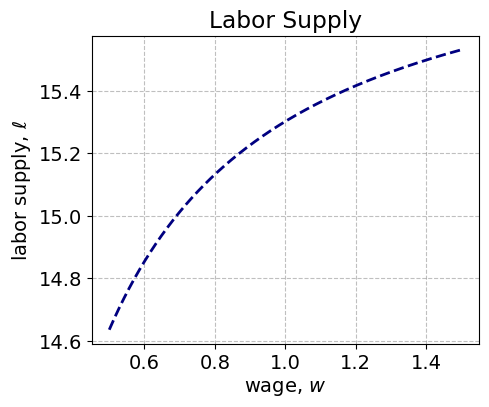

In [24]:
#We first set the parameters
alpha = 0.5
kappa = 1.0
v = 1 / (2 * 16 ** 2)
w = 1.0
tau = 0.30

#We create a linear space for wages from 0.5 to 1.5 to find the optimum labour
N = 1_000
w_vec = np.linspace(0.5,1.5,N)
l_vec = np.zeros(N)

for i in range(N):
    w=w_vec[i]
    l_vec[i] = maximize_u()
    
#we plot the solutions:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec, l_vec, '--', linewidth=2, color='navy')
ax.set_ylabel('labor supply, $\ell$')
ax.set_xlabel('wage, $w$')
ax.set_title('Labor Supply')


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Text(0.5, 1.0, 'Utility')

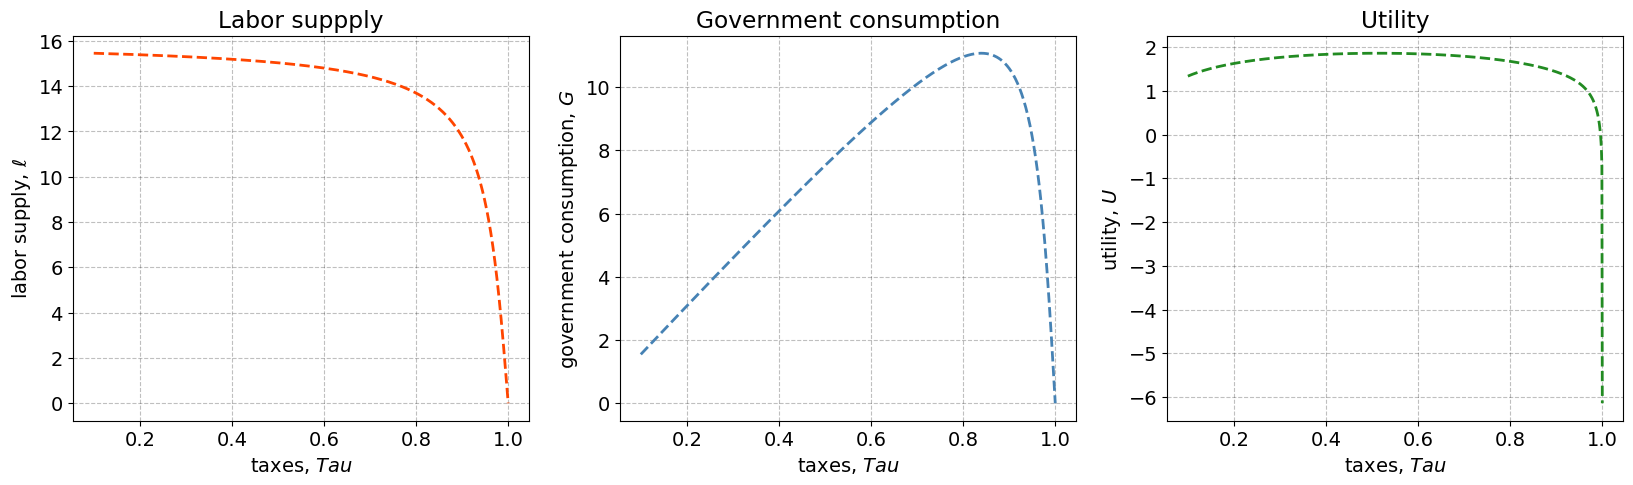

In [25]:
#We first set the parameters
alpha = 0.5
kappa = 1.0
v = 1 / (2 * 16 ** 2)
w = 1.0

#We create a linear space for tau to check how the labour and government consumption change
N = 1_000
tau_vec = np.linspace(0.1,1.0,N)
l_vec = np.zeros(N)
g_vec = np.zeros(N)
u_vec = np.zeros(N)

for i in range(N):
    tau = tau_vec[i]
    l_vec[i] = maximize_u()
    g_vec[i] = tau*w*l_vec[i]
    c_val = c(l_vec[i], kappa, tau, w) #we calcule the value of c to evaluate the following function
    u_vec[i] = u(c_val, l_vec[i], alpha, v, g_vec[i])

#we plot the solutions:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(tau_vec,l_vec, '--', linewidth=2, color='orangered')
ax.set_xlabel('taxes, $Tau$')
ax.set_ylabel('labor supply, $\ell$')
ax.set_title('Labor suppply')

ax = fig.add_subplot(1,3,2)
ax.plot(tau_vec,g_vec, '--', linewidth=2, color='steelblue')
ax.set_xlabel('taxes, $Tau$')
ax.set_ylabel('government consumption, $G$')
ax.set_title('Government consumption')

ax = fig.add_subplot(1,3,3)
ax.plot(tau_vec,u_vec, '--', linewidth=2, color='forestgreen')
ax.set_xlabel('taxes, $Tau$')
ax.set_ylabel('utility, $U$')
ax.set_title('Utility')

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

FROM THE PREVIOUS EXCERCISE: the index where the utility is higher is: [460] and the tau that corresponds that index is: 0.337838
FOR THIS EXCERCISE: After the maximization, the tau that maximizes the utility is: 0.522591 with an utility 1.969725


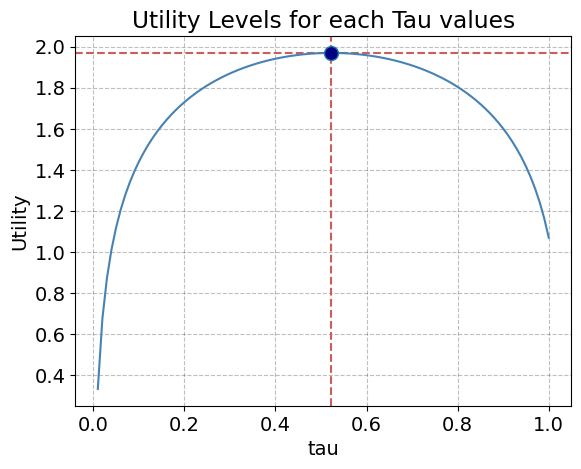

In [26]:
#from the previous exercise, we can check which the tau is related with the highest utility
print("FROM THE PREVIOUS EXCERCISE: the index where the utility is higher is:", np.where(u_vec==max(u_vec))[0], "and the tau that corresponds that index is: {:.6f}".format(tau_vec[264]))

#this can also be found doing a maximization of the utility function, and having two parameters to decide, l and tau
#We first set the parameters
alpha = 0.5
kappa = 1.0
v = 1 / (2 * (16**2))
w = 1.0

# Now, we write the utility function including the restriction and the new function of g in it
def u_new(kappa, alpha, v, w, l, tau): #utility
    if math.isclose(((kappa + ((1 - tau)*w*l))**alpha * (tau*w*l)**(1 - alpha)),0) : #if the value of the expression inside the log is close to zero, the utility is - infinity
        utility = float('-inf')
    else :
        utility = math.log((kappa + ((1 - tau)*w*l))**alpha * (tau*w*l)**(1 - alpha))
    
    desutility = v * ((l**2)/2)

    return utility - desutility

# Now, we will maximize the utility with the constraint of l [0,24] and tau (0,1)
def maximize_u_new():
    bounds = [(0, 24), (0.01, 1.0)]  # Bounds for l and tau
    initial_guess = (15, 0.5)
    res = optimize.minimize(lambda x: -u_new(kappa, alpha, v, w, x[0], x[1]), initial_guess, bounds=bounds)
    l_star, tau_star = res.x
    return l_star, tau_star

l_star, tau_star = maximize_u_new()
u_star = u_new(kappa, alpha, v, w, l_star, tau_star)
print("FOR THIS EXCERCISE: After the maximization, the tau that maximizes the utility is:", "{:.6f}".format(tau_star), "with an utility", "{:.6f}".format(u_star) )

# Plotting utility levels for each tau
tau_range = np.linspace(0.01, 1.0, 100)  # Range of tau values
utility_levels = [u_new(kappa, alpha, v, w, l_star, tau) for tau in tau_range]

plt.axvline(x=tau_star, color='indianred', linestyle='--')
plt.axhline(y=u_star, color='indianred', linestyle='--')
plt.plot(tau_range, utility_levels, color='steelblue', linestyle='-')
plt.plot(tau_star, u_star, marker='o', markersize=10, markerfacecolor='navy')
plt.plot()
plt.xlabel('tau')
plt.ylabel('Utility')
plt.title('Utility Levels for each Tau values')
plt.show()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [27]:
# First of all, we set the parameters.
alpha = 0.5
kappa = 1.0
v = 1 / (2 * 16**2)
w = 1.0
tau = tau_star # Note: The tau is from question 4

sigma_list = [1.001, 1.5]
rho_list = [1.001, 1.5]
epsilon_list = [1.0, 1.0]

# Now, we write the general utility function including the restriction and
def u_gen(kappa, alpha, v, w, tau, sigma, rho, epsilon, l): #utility
    numerator = (( (alpha*(kappa + ((1 - tau)*w*l)) ** ((sigma-1)/sigma)) + ((1-alpha)*(tau*w*l)**((sigma-1)/sigma)) ) ** (sigma/(sigma-1)))
    numerator = numerator ** (1-rho) -1
    denominator= 1-rho

    utility=numerator/denominator

    desutility = v * ((l**(1+epsilon)) / (1+epsilon))

    return utility - desutility

#We define the maximization
def maximize_u_gen():
    obj = lambda l: -u_gen(kappa, alpha, v, w, tau, sigma, rho, epsilon, l)
    res = optimize.minimize_scalar(obj, bounds=(0, 24), method='bounded')
    return res.x

#we value the government consumption
def g_gen(tau,w,l_star_gen):
    return tau*w*l_star_gen

# Now, we maximize the utility with the constraint of l [0,24] and the different values of sigma, rho, and epsilon
for i in (0,1):
    sigma=float(sigma_list[i])
    rho=float(rho_list[i])
    epsilon=float(epsilon_list[i])

    l_star_gen = maximize_u_gen()
    g_star_gen=g_gen(tau,w,l_star_gen)
    print("For the parameters sigma:", sigma, ", rho:", rho, ", and epsilon:", epsilon, ", the consumption of the government is: {:.6f}".format(g_star_gen))

For the parameters sigma: 1.001 , rho: 1.001 , and epsilon: 1.0 , the consumption of the government is: 11.552034
For the parameters sigma: 1.5 , rho: 1.5 , and epsilon: 1.0 , the consumption of the government is: 6.974344


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [28]:
# Setting the parameters:
alpha = 0.5
kappa = 1.0
v = 1 / (2 * 16 ** 2)
w = 1.0
par_set = [{'sigma': 1.001, 'rho': 1.001, 'epsilon': 1.0},
           {'sigma': 1.5, 'rho': 1.5, 'epsilon': 1.0}]

def u_gen2(kappa, l, tau, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * l
    num = ((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma -1))) ** (1 - rho)
    den = v * l ** (1 + epsilon) / (1 + epsilon)
    return (num - 1) / (1 - rho) - den

def obj(tau, sigma, rho, epsilon):
    l_star_d = optimize.minimize(lambda l: -u_gen2(kappa, l, tau, tau * w * l, sigma, rho, epsilon),
                        x0=1, bounds=((0, 24),))
    if l_star_d.success:
        l_star = l_star_d.x[0]
        return -u_gen2(kappa, l_star, tau, tau * w * l_star, sigma, rho, epsilon)
    else:
        return np.inf

for pars in par_set:
    res = optimize.minimize(lambda tau: obj(tau, **pars), x0=[0.5], bounds=((0, 1),))
    if res.success:
        print(f'The optimal tax rate given {pars} is {res.x[0]:.6f}')
    else:
        print(f'Optimization is not possible for the given parameters: {pars}')


The optimal tax rate given {'sigma': 1.001, 'rho': 1.001, 'epsilon': 1.0} is 0.500000
The optimal tax rate given {'sigma': 1.5, 'rho': 1.5, 'epsilon': 1.0} is 0.537546


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [29]:
# First we define the profit function
def profit_fun(l, k, n, w):
    p = k * l ** (-n)
    return p * l - w * l # Indirectly, we are plugging in the price function in the profit function

# Secondly, we are setting the maximization
def maximize_profit(k, n, w):
    objective = lambda l: -profit_fun(l, k, n, w)
    result = optimize.minimize_scalar(objective, method='bounded', bounds=(0, 1000))
    opt_l = result.x
    opt_profit = -result.fun
    return opt_l, opt_profit

# Parameters. Remember we have already defined the eta and w values. we have a k in a range from 1 to 2
n = 0.5
w = 1.0
k_values = [1.0 + 1 * i for i in range(2)]

for k in k_values: # Note: This is the only outcome we are showing with more than 6 decimals, otherwise when rounded the professor could not appretiate the right result.
    opt_l, opt_profit = maximize_profit(k, n, w)
    print(f"For k = {k:.1f}:")
    print(f"The optimal value of l is: {opt_l:.12f}")
    print(f"With a maximum profit of: {opt_profit:.12f}")
    print()

For k = 1.0:
The optimal value of l is: 0.249999957869
With a maximum profit of: 0.250000000000

For k = 2.0:
The optimal value of l is: 0.999998792615
With a maximum profit of: 1.000000000000



We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [30]:
from scipy.stats import norm

# First of all, we could set the parameters
rho = 0.90
iota = 0.01
sigma = 0.10
R = (1 + 0.01) ** (1/12)
n = 0.5
k_ini = 1
w = 1.0
K = 10000  # Number of Shocks we want. We denoted as "S" but actually it's S=K in the model. We did that to avoid confusions. Note: Less make faster the estimation but many make it more aquarate

# Here, we are coding to obtain the random walk
def h_fun(epsilon_series):
    l_ini = 0  # Initial value of l
    h = 0  # Accumulator for h

    for t in range(119): # Remember that we have to set in 119 since the zero is accounted as a first observation
        k_log = np.exp(rho * np.log(k_ini) + epsilon_series[t])
        l = ((1 - n) * k_log / w) ** (1 / n)
        h += R ** (-t) * (k_log * l ** (1 - n) - w * l - (l != l_ini) * iota)
        l_ini = l

    return h

# Generating the random shock series
np.random.seed(0)
epsilon_series = norm.rvs(loc=-0.5 * sigma**2, scale=sigma, size=(K, 119)) # we use the function norm.rvs to generate the shock series since it's more simple and easier. As you can see, it follows a normal distribution according with the parameters given.

# Finally, we estimate the H value. The reasoning of this part is that we obtained the expected value by averaging the values of h over the shocks
H = np.mean([h_fun(epsilon) for epsilon in epsilon_series])

print(f"Expected value of the salon (H): {H:.6f}")

Expected value of the salon (H): 27.498108


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.




**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [31]:
# To calculate the H with a Delta = 0.05 we have to re-define the function setted to find h. 
# We include the policy using the for-in and if-else tools
def h_fun_delta(epsilon_series, delta):
    l_ini = 0  # Initial value of l
    h = 0  # we set an initial value of h=0 to start the iteration. It is just the initial value
    for t in range(119): # Remember that we have to set in 119 since the zero is accounted as a first observation
        k_log = np.exp(rho * np.log(k_ini) + epsilon_series[t]) # we set as a k_log to avoid confutions for the las k's estimated
        l_star = ((1 - n) * k_log / w) ** (1 / n) # The same case as before
        if t == 0:
            l = l_star
        else:
            if abs(l - l_star) > delta:
                l = l_star
            else:
                l = l_ini
        h += R ** (-t) * (k_log * l ** (1 - n) - w * l - (l != l_ini) * iota)
        l_ini = l
    return h

H_delta = np.mean([h_fun_delta(epsilon, 0.05) for epsilon in epsilon_series])
print(f"Expected value of the salon with delta=0.05 (H_delta): {H_delta:.6f}")

print(f"The new policy implemented improves the profitability in: {((H_delta/H)-1)*100:.6f}%")

Expected value of the salon with delta=0.05 (H_delta): 28.041971
The new policy implemented improves the profitability in: 1.977820%


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [32]:
# First we make a set of values for Delta. The wider the set, the more accurate the approximation will be.
delta_values = np.arange(0.01, 0.5, 0.01) 
max_H = -np.inf # This line is important because by being initialized to the lowest value, we ensure that when the maximum value is calculated in the subsequent code, any other value will be greater than this initialized value
max_delta = 0

H_values = [] # This is the dictionary where we are gonna storage the values of H for each delta
for delta in delta_values:
    H_delta = np.mean([h_fun_delta(epsilon, delta) for epsilon in epsilon_series]) # We just use the function created in the last question
    H_values.append(H_delta) # Here, we are saving the outputs
    if H_delta > max_H: 
        max_H = H_delta
        max_delta = delta

print(f"Delta value that maximizes H: {max_delta:.6f}")
print(f"Expected value of the salon with delta={max_delta:.6f} (H_delta): {max_H:.6f}")

KeyboardInterrupt: 

In [ ]:
# Here we just make the graph to ilustrate the answer obtained
plt.axvline(x=max_delta, color='indianred', linestyle='--')
plt.axhline(y=max_H, color='indianred', linestyle='--')
plt.plot(delta_values, H_values, marker='o', markersize=5, markerfacecolor='lightblue')
plt.plot(max_delta, max_H, marker='o', markersize=10, markerfacecolor='navy')
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('Delta value that maximizes H')
plt.show()


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In Question 3, the policy states that if the absolute difference between the previous period's labor level and the optimal labor level (given by $\ell_t^*$) is greater than a certain value $\Delta$, then the Salon will adjust its labor level to the optimal level. Otherwise, it will maintain its previous labor level.

Essentially, this is a way to minimize its labor adjustment costs by only adjusting them when it is absolutely necessary. The value of $\Delta$ determines how sensitive the Salon is to changes in its optimal labor level. If $\Delta$ is high, that means the Salon will only adjust its labor level when there are significant changes in its optimal level. However, if $\Delta$ is low or zero, it will adjust its labor level more frequently, which could lead to higher labor adjustment costs.

**Alternative Policy**

An alternative policy could be to decrease the level of uncertainty faced by workers when deciding how much to work. The approach is introducing a long-term contract between the workers and the firm, which guarantees a stable wage rate over a certain period of time. By doing this, workers will be less likely to reduce their labor supply due to fear of wage cuts. It could also be complemented providing workers with training opportunities, which will increase their human capital and bargaining power, thus reducing the level of adjustment costs.

Is this new policy goin to result in a better value of the Salon? Well, we will see..

In [ ]:
# First of all, we recall the structure of the funtion used in Question 2, before the policy.
# We use this function to incorporate the new policy
def h_fun_contract(epsilon_series, wage_rate, contract_length):
    l_ini = 0  # Initial value of l
    h = 0  # we set an initial value of h=0 to start the iteration. It is just the initial value
    for t in range(119): # Remember that we have to set in 119 since the zero is accounted as a first observation
        k_log = np.exp(rho * np.log(k_ini) + epsilon_series[t]) # we set as a k_log to avoid confutions for the las k's estimated
        l_star = ((1 - n) * k_log / wage_rate) ** (1 / n) # The same case as before

        # Now, the best part. Incorporate the long-term contract policy
        if t % contract_length == 0: # Here we set the rules for decision. If the contrat is in a monthly scheme, is the same logic as question 2
            l_contract = l_star
        else:
            l_contract = l

        h += R ** (-t) * (k_log * l_contract ** (1 - n) - wage_rate * l_contract - (l_contract != l_ini) * iota)
        l_ini = l_contract
        l = l_star
    return h

# Then we define the lenght of contrats and the hypotetical increment of wage
wage_rate = 1.1 # Asumme an increment of 10%
contract_length = 12 # Asumme contracts for one year, it means 12 months

# Finally, we calculate the expected value of H using the new policy
H_contract = np.mean([h_fun_contract(epsilon, wage_rate, contract_length) for epsilon in epsilon_series])

# Compare the profit improvement with the original policy
print(f"Expected value of the salon with long-term contract policy: {H_contract:.6f}")
print(f"The new policy implemented improves the profitability in: {((H_contract/H)-1)*100:.6f}%, so it's better not to follow it")

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [ ]:
# We set the parameters
K_min = 10  # Minimum value for k
k_values = np.linspace(10, 500, 500)  # Using k-values from 10 to 500 generated 500 times

# Then, we calculate the effectiveness of the initial value, which depends on chi^k.
chi_k = 0.50 * 2 / (1 + np.exp((k_values - K_min) / 100))

# And, ploting a good graph
plt.plot(k_values, chi_k, linewidth=2.5, color='salmon', linestyle='--')
plt.xlabel('$k$')
plt.ylabel('$x^{k0}$')
plt.title('Effectiveness of initial guess with increasing k')
plt.grid(True)
plt.show()

**Interpretation**

From the graph above, as $k$ increases the effectiveness of the initial guess decreases. This is because the algorithm requires a higher number of iteration to find the global minimum. If it requires less number of iterations to find the global minimum, then the initial guess was an effective and potent guess.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
def multi_start_global_optimizer(bounds, K, K_min, tol): # defining the optimizer
    x_ast = np.random.uniform(bounds[:, 0], bounds[:, 1]) # random drawing values of x1 and x2
    f_ast = griewank(x_ast)                             # function of x* (new values of x)
    for k in range(k):                                   
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1]) # creating a loop
        if k >= K_min:                                      # if k is larger than warm-up iterations
            chi_k = 0.50 * 2 / (1 + np.exp((k - K_min) / 100)) 
            x_k0 = chi_k * x_k + (1 - chi_k) * x_ast 
        else:
            x_k0 = x_k
        res = minimize(griewank, x_k0, method='BFGS', tol=tol)
        if res.fun < f_ast:   # if the optimized initial guess is less than the previous value of x, set them equal to eachother. 
            f_ast = res.fun # This will cause the algorithm to use the lowest value to iterate to advance towards the global minimum.
            x_ast = res.x
    return x_ast

bounds = np.array([[0.001, 600], [0.001, 600]]) # bounds for x1 and x2
tol = 1e-8  # tolerance level
K_min = 10  # warm-up iterations
K = 1000
k = 200 # number of iterations

x_ast = np.random.uniform(bounds[:, 0], bounds[:, 1])
fig, ax = plt.subplots(figsize=(8, 8))
for k in range(k):
    x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])
    if k >= K_min:
        chi_k = 0.50 * 2 / (1 + np.exp((k - K_min) / 100))
        x_k0 = chi_k * x_k + (1 - chi_k) * x_ast
    else:
        x_k0 = x_k
    ax.scatter(x_k0[0], x_k0[1], c='teal', alpha=0.5, s=50)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title("Warm-up iteration = 10 and number of iterations = 100")
plt.show()

In [ ]:
# With K_bar equal 100
K_min = 100

fig, ax = plt.subplots(figsize=(8, 8))
for k in range(k):
    x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])
    if k >= K_min:
        chi_k = 0.50 * 2 / (1 + np.exp((k - K_min) / 100))
        x_k0 = chi_k * x_k + (1 - chi_k) * x_ast
    else:
        x_k0 = x_k
    ax.scatter(x_k0[0], x_k0[1], c='indianred', alpha=0.5, s=50)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title("Warm-up iteration = 100")
plt.show()

**Interpretation**

Smaller $\underline{K}$ will equal a faster convergence. Higher $\underline{K}$ will result in a greater spread and thus a no concrete convergence to a point. Furthermore, increasing the $\underline{K}$ will increase the exploration degree, which can result in longer convergence. 

$\chi^k$ represents the weight of the previous value on the new value and depends on $\underline{K}$. If $\chi^k$ is low the previous value has a high effect on the new value. Thus, reducing exploration and shifts more towards utilizing the current solution area. Vice versa if $\chi^k$ is high the previous value has no effect on the new value, and the exploration degree will be higher and spread out to more solution areas.  

This is shown in the second and third graphs above. The second graph represents a $\underline{K}$ equal 10, where the convergence is faster and the solution area is less spread out. The third graph represents a $\underline{K}$ equal 100, where the solution area a more spread out.



In summary, increasing $\underline{K}$ will mean a high $\chi^k$ value, which will result in a slower convergence than with a low $\underline{K}$.